In [1]:
# 1. FHIR (Fast Healthcare Interoperability Resources)
import json
from datetime import datetime, timedelta
import random

class FHIRClient:
    def __init__(self, client_id, name, date_of_birth, gender):
        self.client_id = client_id
        self.active = True
        self.name = [{"First": name.split()[0], "Last": name.split()[-1]}]
        self.date_of_birth = date_of_birth
        self.gender = gender.lower()

    def to_fhir_json(self):
        return json.dumps({
            "resourceType": "Patient",
            "id": self.client_id,
            "active": self.active,
            "name": self.name,
            "birthDate": self.date_of_birth,
            "gender": self.gender
        }, indent=2)

class OMOPProcessor:
    def __init__(self):
        self.conditions = {
            "Hypertension": "59621000",
            "Diabetes": "44054006",
            "Asthma": "195967001"
        }

    def _map_race(self, race):
        race_map = {
            "White": "2106-3",
            "Black or African American": "2054-5",
            "Asian": "2028-9",
            "Other": "2131-1"
        }

    def create_person_record(self, pid, birth_date, gender, race):
        return {
            "person_id": pid,
            "birth_datetime": birth_date,
            "gender_concept_id": 8507 if gender.lower() == 'male' else 8532,
            "race_concept_id": self._map_race(race),
        }
    
    def create_condition_occurrence(self, condition_name, pid, start_date):
        if condition_name not in self.conditions:
            raise ValueError(f"Condition '{condition_name}' not recognized.")
        return {
            "condition_occurrence_id": f'{pid}_{condition_name}_{start_date}',
            "person_id": pid,
            "condition_concept_id": self.conditions[condition_name],
            "condition_start_date": start_date,
            "condition_type_concept_id": 32020
        }

In [ ]:
def generate_synthetic_data(
    num_patients=15, 
    first_names = ["John", "Jane", "Alice", "Bob", "Charlie", "Diana"],
    last_names = ["Smith", "Doe", "Johnson", "Brown", "Davis", "Miller"],
    genders = ['M', 'F'],
    races = ["White", "Black", "Asian", "Hispanic", "Other"],
    conditions = ["Hypertension", "Diabetes", "Asthma", "Depression", "Anxiety"]
):
    patients = []
    omop_processor = OMOPProcessor()

    for i in range(num_patients):
        pid = f'P{i+1:03d}'
        name = f"{random.choice(first_names)} {random.choice(last_names)}"
        date_of_birth = (datetime.now() - timedelta(days=random.randint(18*365, 80*365))).strftime('%Y-%m-%d')
        gender = random.choice(genders)
        race = random.choice(races)
        condition = random.choice(conditions)
        condition_start_date = (datetime.now() - timedelta(days=random.randint(0, 3650))).strftime('%Y-%m-%d')

        fhir_patient = FHIRClient(pid, name, date_of_birth, gender)
        person = omop_processor.create_person_record(pid, date_of_birth, gender, race)
        condition_occurrence = omop_processor.create_condition_occurrence(condition, pid, condition_start_date)

        patients.append({
            "fhir": json.loads(fhir_patient.to_fhir_json()),
            "OMOP_person": person,
            "OMOP_condition": condition_occurrence,
            "race": race,
            "gender": gender,
            "condition": condition,
            "birth_year": int(date_of_birth.split('-')[0])
        })
    return patients

In [37]:
import pandas as pd
patients = generate_synthetic_data(num_patients=20)

#print(patients[0]["fhir"])

In [41]:
import pandas as pd
import json
import matplotlib.pyplot as plt

df = pd.DataFrame([{
    "PatientID": p["fhir"]["id"],
    "Name": p["fhir"]["name"][0]["First"] + " " + p["fhir"]["name"][0]["Last"],
    "Gender": p["fhir"]["gender"],
    "Race": p["race"],
    "BirthYear": p["birth_year"],
    "Condition": p["condition"]
} for p in patients])

print(df.head())

  PatientID           Name  Gender   Race  BirthYear     Condition
0      P001    Alice Smith  female  Other       1997  Hypertension
1      P002  Jane Williams    male  Asian       1989      Diabetes
2      P003   Dolly Garcia  female  Asian       1990      Diabetes
3      P004    John Garcia  female  Black       1976        Asthma
4      P005    Alice Jones    male  Other       1959      Diabetes



### Value Counts of Categorical Variables ###

Condition Counts:
 Condition
Hypertension    8
Diabetes        7
Asthma          5
Name: count, dtype: int64

Gender Distribution:
 Gender
female    11
male       9
Name: count, dtype: int64

Race Distribution:
 Race
Black    7
Other    6
White    4
Asian    3
Name: count, dtype: int64

### Descriptive Statistics for Birth Year ###
count      20.000000
mean     1980.450000
std        14.883672
min      1947.000000
25%      1970.250000
50%      1984.500000
75%      1989.250000
max      2005.000000
Name: BirthYear, dtype: float64


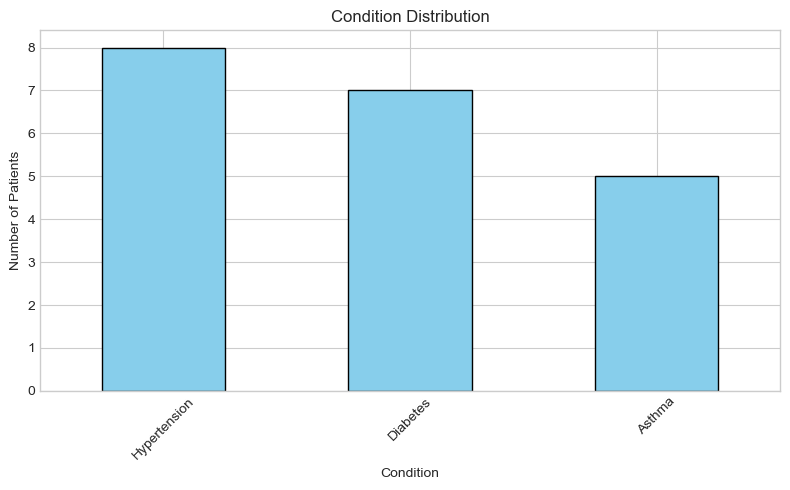

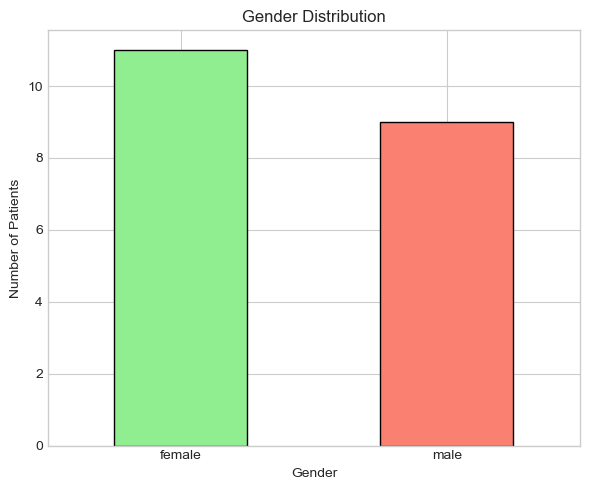

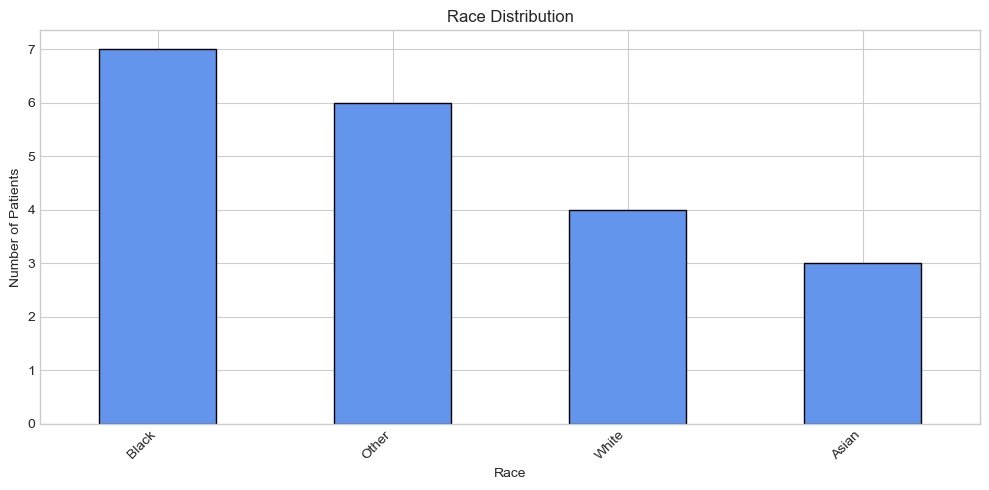

In [42]:
print("\n### Value Counts of Categorical Variables ###")
print("\nCondition Counts:\n", df["Condition"].value_counts())
print("\nGender Distribution:\n", df["Gender"].value_counts())
print("\nRace Distribution:\n", df["Race"].value_counts())

print("\n### Descriptive Statistics for Birth Year ###")
print(df["BirthYear"].describe())

# 4. Create data visualizations
plt.style.use('seaborn-v0_8-whitegrid')

# Plot Condition Distribution
plt.figure(figsize=(8, 5))
df["Condition"].value_counts().plot(kind="bar", color='skyblue', edgecolor='black')
plt.title("Condition Distribution")
plt.xlabel("Condition")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Gender Distribution
plt.figure(figsize=(6, 5))
df["Gender"].value_counts().plot(kind="bar", color=['lightgreen', 'salmon'], edgecolor='black')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot Race Distribution
plt.figure(figsize=(10, 5))
df["Race"].value_counts().plot(kind="bar", color='cornflowerblue', edgecolor='black')
plt.title("Race Distribution")
plt.xlabel("Race")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()